# Bonding Curves in Action: Uniswap

In [31]:
import streamlit as st
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
from math import sqrt
import scipy.stats as sts
from PIL import Image
plt.rcParams["figure.figsize"]=10,5
%matplotlib inline

### A quick visual reminder of impermanent loss

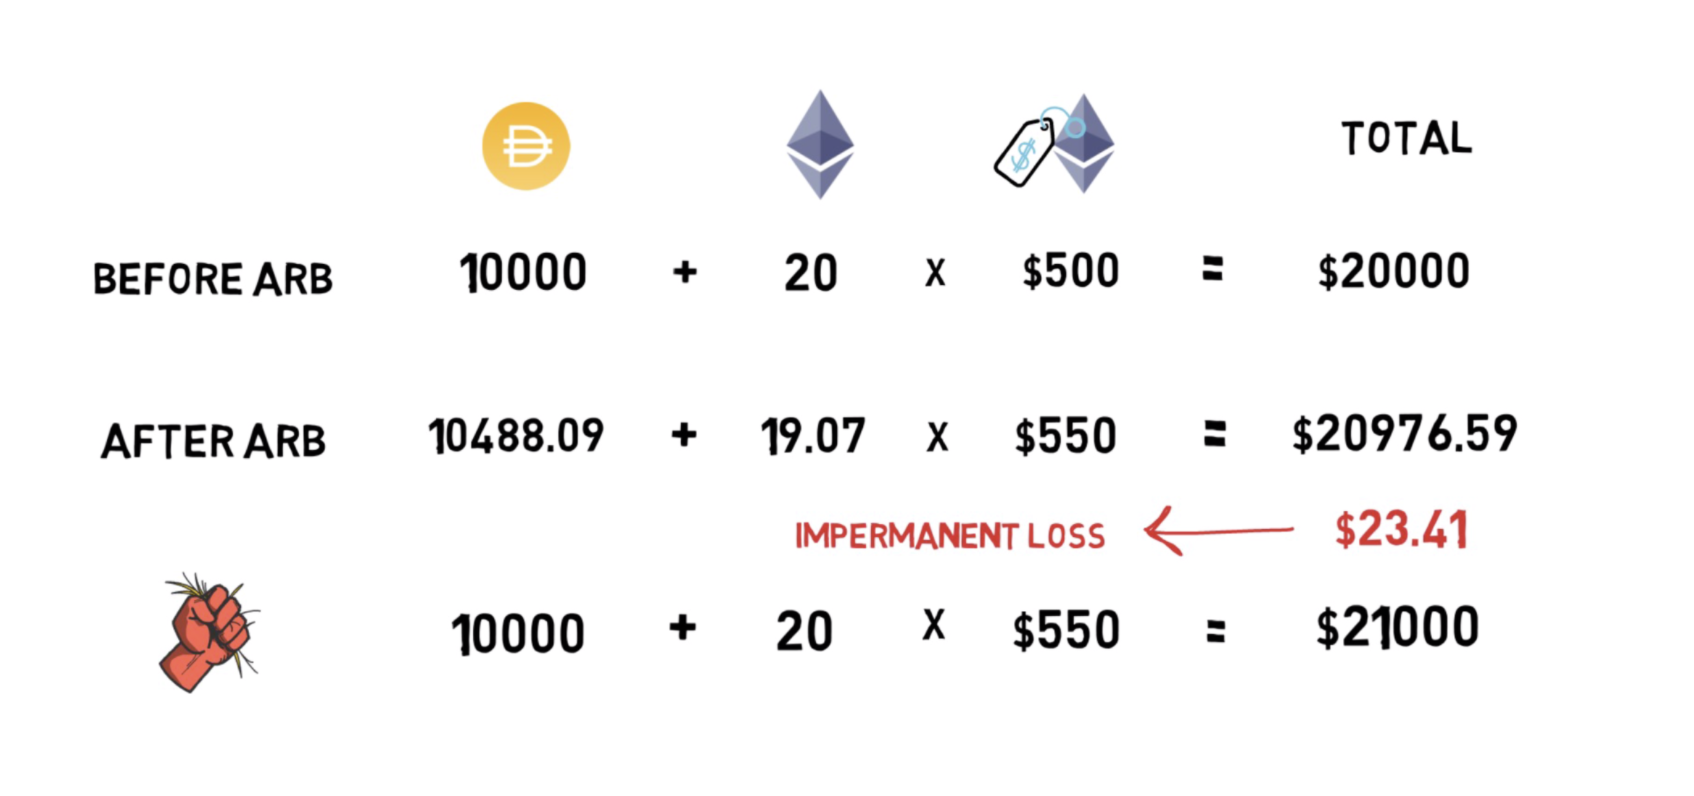

In [33]:
file_location = '/Users/rebeccamqamelo/Desktop/IMF/Impermanent Loss.png' # edit this!
display(Image.open(file_location))

### Setting up the simulation

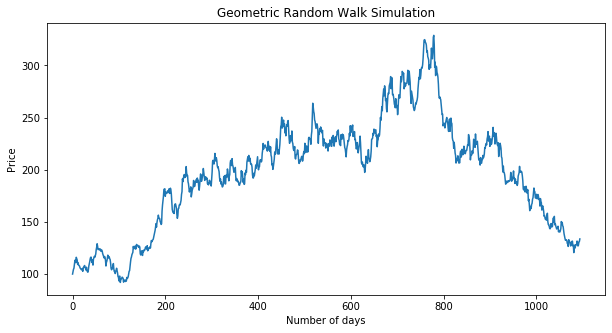

In [35]:
# Simulate GBM: Ethereum price follows a Brownian Motion

class GBM():

    def __init__(self, start_price = None, time = None, drift = 0, volatility = 1):
        '''
        time: time in years
        drift: mu, per year, calculated on calendar year (365 days instead of 252 days)
        volatility: stan$dard deviation sigma, per square root year, calculated on calendar year (365 days instead of 252 days)
        '''
        self.time = time
        self.drift = drift
        self.volatility = volatility
        self.dt = 1/365 # Assume that each time step is for one day
        self.price = [start_price]

    def simulation(self):
        for i in range(round(self.time*365)-1):
            S_t = self.price[-1]
            ### Fill in the code below
            Z_t = sts.norm.rvs(loc=0, scale=1)
            dS =  S_t * (self.drift * self.dt + self.volatility * np.sqrt(self.dt) * Z_t)
            self.price.append(S_t + dS)
    
    def display(self):
        plt.figure(figsize=(10, 5))
        plt.plot(range(round(self.time*365)), self.price)
        plt.title('Geometric Random Walk Simulation')
        plt.xlabel('Number of days')
        plt.ylabel('Price')
        plt.show()


a = GBM(start_price = 100, time = 3, drift = 0, volatility = 0.4) # Assume the drift is zero.
a.simulation()
a.display()

### Simulating impermanent loss

From the blogpost on impermanent loss:

**Let’s say Alice buys 1 ETH for 300 USDT using the ETH/USDT liquidity pool.** 
* By doing that, she increases the USDT portion of the pool and decreases the ETH portion of the pool. This effectively means that the price of ETH goes up. Why? 
* There is less ETH in the pool after the transaction, and we know that the total liquidity (k) must remain constant. This mechanism is what determines the pricing. 
* Ultimately, the price paid for this ETH is based on how much a given trade shifts the ratio between x and y.

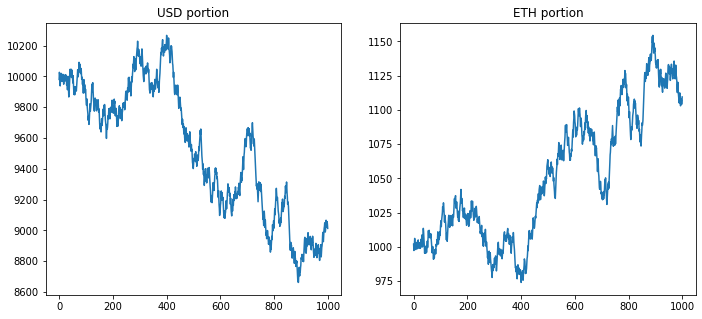

In [26]:
# Rules:
# k is always constant and is equal to: x * y = k (x for ETH, y for USDT)

history = []
eth = 1000
usd = 10000
k = usd * eth

for i in range(1000):
    if np.random.random() > .5: usd += np.random.randint(low=10, high=50)
    else: usd -= np.random.randint(low=10, high=50)
    history.append([usd, k / usd]) # append the ETH price

plt.figure(figsize=(18, 5))
plt.subplot(1,3,1); plt.title('USD portion')
plt.plot(np.array(history)[:,0])

plt.subplot(1,3,2); plt.title('ETH portion')
plt.plot(np.array(history)[:,1]);

**Let’s say that Alice deposits 1 ETH and 100 USDT in a Uniswap pool.**

* Since the token pair needs to be of equivalent value, this means that the price of ETH is 100 USDT.  
* At the same time, there’s a total of 10 ETH and 1,000 USDT in the pool – the rest funded by other liquidity providers just like Alice. 
* This means that Alice has a 10% share of the pool. Our total liquidity (k), in this case, is 10,000.

**What happens if the price of ETH increases to 400 USDT?** 

_Note: In the code cell below, we'll simulate multiple ETH price changes using the Brownian Motion Simulation above._
* Remember, the total liquidity in the pool has to remain constant.
* If ETH is now 400 USDT, that means that the ratio between how much ETH and how much USDT is in the pool has changed. 
* As a matter of fact, there is 5 ETH and 2,000 USDT in the pool now. Why? 
* Arbitrage traders will add USDT to the pool and remove ETH from it until the ratio reflects the accurate price. 
* This is why it’s crucial to understand that k is constant.

**So, Alice decides to withdraw her funds and gets 10% of the pool according to her share.** 
* As a result, she gets 0.5 ETH and 200 USDT, totaling 400 USDT. 
* It seems like she made a nice profit. 
* But hang on, what would have happened if she didn’t put her funds in the pool? She’d have 1 ETH and 100 USDT, totaling 500 USDT.

In [27]:
from scipy.optimize import fsolve

def equations(p):
    eth_portion, usd_portion = p
    
    # Returns the new eth portion and the new usdt portion in the pool
    return (eth_portion - (10000 / usd_portion), usd_portion - (eth_price * eth_portion))


# Starting with 1 ETH worth $100 
eth_portion = 10
usd_portion = 1000

solutions, portfolio = [], []
total_liquidity = eth_portion * usd_portion

for eth_price in a.price:
    eth_portion, usd_portion = fsolve(equations, (100, 100))
    
    # Alice owns 10% of the pool, so we multiply by .1 below:
    portfolio.append([.1*eth_portion + .1*usd_portion, eth_price])

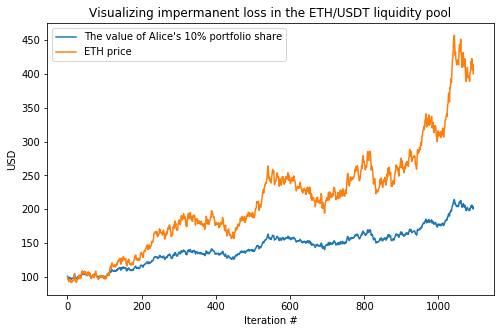

In [28]:
plt.figure(figsize=(8, 5))
plt.title('Visualizing impermanent loss in the ETH/USDT liquidity pool')
plt.xlabel('Iteration #')
plt.ylabel('USD')
plt.plot(np.array(portfolio)[:,0], label="The value of Alice's 10% portfolio share"); plt.plot(np.array(portfolio)[:,1], label='ETH price'); plt.legend()

### Questions

1. Re-run the cell that simulates ETH prices. Now when you calculate the difference between the ETH price and Alice's share in the pool, what do you find? 
2. Is there some relationship between ETH prices and impermanent loss? Is there some generalizable relationship here?
3. What kind of bonding curve is represented by a Uniswap liquidity pool (i.e. how does the token price of a liquidity pool share relate to the supply of its underlying assets?)
4. Most analysts agree that as a liquidity provider, the only time your profits are "safe" is when your earned trading fees are greater that your impermanent loss. What does this say about this kind of investment strategy and who it's most likely to benefit?
5. Not all liquidity pools are between ETH and a "stablecoin". If you were to invest in a Uniswap liquidity pool right now, what criteria would you use for the underlying tokens in the pool you select? 